<a href="https://colab.research.google.com/github/gpandu/Facial-Landmark-Detection/blob/master/landmarks_detection_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Facial Landmarks Detection**



In this Notebook, I have implemented Facial landmarks(key points) detection system using Convolution Neural networks and image processing. This project uses Keras with TensorFlow in the backend, opencv and dlib.  Facial landmark detection is regression kind of task where output is set of values representing positions in the image rather than one hot encodings used for classification task. For any task of processing facial features, first step will detecing faces in the image. There open source implemetations available for Face detection with libraries like OpenCV and Dlib. Dlib's face detection works well compared to other as it uses powerfull HOG features trained with SVM. First step of Facial Landmarks detection detecting This project is divided mainly into three parts.


## **Part1:**
This part inlcudes collecting data and processing it as required by the model. Collected Kaggle's facial landmark detection dataset that can be found [here](https://www.kaggle.com/c/facial-keypoints-detection/data). This dataset has a training file which contains each image with 96 by 96 size and 30 landmarks in csv format. Test file contains only image data and we need to predict 
landmarks for the images. Both files can loaded directly if you are running notebook locally. If you are using Colaboratory, you can load the files from google drive using thier api. Once we load the files, we need to arrange the data into Tensors either (m,h,w,c) or (c,h,w,m) format as keras api accepts inputs of these formats.


training/test data: training.csv
Successfully loaded the files.
Input data shape == (2140, 96, 96, 1)
Output shape == (2140, 30)
Sample 1 normalised key points:
 [ 0.4330242  -0.21624877 -0.3466828  -0.3463223   0.25858903 -0.1851669
  0.5810062  -0.1878271  -0.16970447 -0.23996718 -0.5165956  -0.3564843
  0.29375893 -0.24669313  0.74820185 -0.32774875 -0.07298451 -0.2971868
 -0.6224353  -0.51643556 -0.0278047   0.24908654  0.334971    0.3931978
 -0.4643302   0.31000873 -0.06167792  0.52398473 -0.08612007  0.5925943 ]


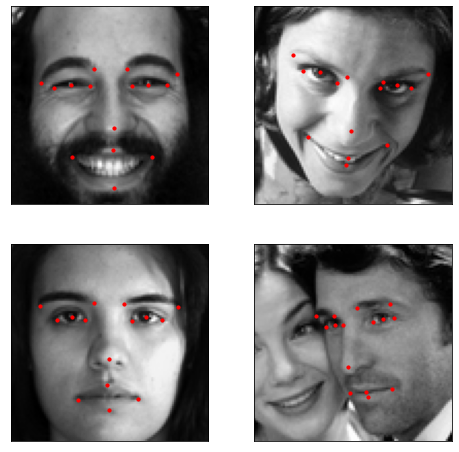

In [ ]:
!pip install pydrive
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import pandas as pd 
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np
from google.colab import files
from sklearn.utils import shuffle

def getFileFromGDrive(train = True):
  # Authenticate and create the PyDrive client.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  # Load training files from drive, eed to provide <File_ID> thats has train and test files
  file_list = drive.ListFile({'q': "'1kUOrh7_fUHM1T76e1GGY5KJ2YbvTFyYR' in parents and trashed=false"}).GetList()   
  
  file_name = file_list[0]['title'] if train else file_list[1]['title']
  print('training/test data: %s' % file_name)
  
  if not os.path.exists(file_name):
    train_downloaded = drive.CreateFile({'id': file_list[1]['id']})
    train_downloaded.GetContentFile('test.csv')
    test_downloaded = drive.CreateFile({'id': file_list[0]['id']})
    test_downloaded.GetContentFile('training.csv') 
    print('Successfully loaded the files.')
   # allows you to temporarily load your file in the notebook VM
  
  df = pd.read_csv(file_name)
  return df

def getFileFromLocal(train = True):
  uploaded = files.upload()
  file_name = 'training.csv' if train else 'test.csv'
  df = pd.read_csv(file_name)
  return df


def loadData(train=True):
  dFrame = getFileFromGDrive(train) #Change this to load file from local  
   # The Image column has pixel values separated by space convert
   # the values to numpy arrays
  dFrame['Image'] = dFrame['Image'].apply(lambda row: np.fromstring(row, sep=' '))
    
  dFrame = dFrame.dropna()  # drop all rows that have missing values in them
  X = np.vstack(dFrame['Image'].values) / 255.  # scale pixel values to [0, 1]
  X = X.astype(np.float32)
  X = X.reshape(-1, 96, 96, 1) # return each images as 96 x 96 x 1
  
  if train:
    y = dFrame[dFrame.columns[:-1]].values
    y = (y - 48) / 48  # scale target coordinates to [-1, 1]
    X, y = shuffle(X, y, random_state=42)  # shuffle train data
    y = y.astype(np.float32)
  else:
    y = None

  return X, y

def plotData(image, landmarks, figure):
    figure.imshow(np.squeeze(image), cmap='gray') # plot the image
    landmarks = landmarks * 48 + 48 # undo the normalization
    # Plot the keypoints
    figure.scatter(landmarks[0::2],landmarks[1::2],marker='o',c='r',s=10)

# Load training set
train_input,train_output = loadData(True)
print("Input data shape == {}".format(train_input.shape))
print("Output shape == {}".format(train_output.shape))
print("Sample 1 normalised key points:\n {}".format(train_output[1]))
    
   # visualize four taining samples
%matplotlib inline
fig = plt.figure(figsize=(8,8))
for i in range(4):
     figure = fig.add_subplot(2, 2, i + 1, xticks=[], yticks=[])
     plotData(train_input[i], train_output[i], figure)

## **Part2:**

Here, we will create CNN architecture usig Keras sequential model. Created a VGG-16 style architecture with 5 covolution layers and 8 layers in total including dense layers. All convolution layers will have filters with same size and follows power of 2 increaments in the no of filters in the next layer. Intermediate layers will have relu activations. Final layer will have only linear activation as we are not predicting the probabilities of one hot encodings.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.layers import Flatten, Dense
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot  as plt

    
#VGG-16 Style Architecture

model  =  Sequential()
model.add(Conv2D(filters=16, kernel_size=3, activation = 'relu', input_shape=(96,96,1)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))


model.add(Dense(30))

print('\n\n CNN Architecture summary_________________________________________')
model.summary()

Using TensorFlow backend.




 CNN Architecture summary_________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
___________________________________________________

  Now, we will compile the model. Compilation involves specifying optimizer that minimizesthe  loss. Mean square error is choosen for loss function as our final layer outputs are linear activation outputs. If you are choosing mini batch training, need to specify batch size. Specifying  epochs or passes is important as it helps to get a better model by traversing various local optimums. We can also specify checkpointer to save the model after one or more no of passes. Verbose can be used to get logging information while training, also can specify level of logging.






In [ ]:
from keras.callbacks import ModelCheckpoint, History
from keras.optimizers import Adam

hist = History()
epochs = 50
#Choose power of 2
batch_size = 32  
filepath='model_weights.ckpt'

checkpointer = ModelCheckpoint(filepath, verbose=1, save_best_only=True, period=5)

#Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

history = model.fit(train_input, train_output, validation_split=0.2, callbacks = [checkpointer,hist],
         batch_size=batch_size, epochs=epochs, verbose=1)


model.save('my_model.h5'),

Train on 1712 samples, validate on 428 samples
Epoch 1/50
1712/1712 [==============================] - 7s 4ms/step - loss: 0.0248 - accuracy: 0.4860 - val_loss: 0.0072 - val_accuracy: 0.6963
Epoch 2/50
1712/1712 [==============================] - 1s 611us/step - loss: 0.0073 - accuracy: 0.6133 - val_loss: 0.0046 - val_accuracy: 0.6963
Epoch 3/50
1712/1712 [==============================] - 1s 605us/step - loss: 0.0061 - accuracy: 0.6437 - val_loss: 0.0045 - val_accuracy: 0.6963
Epoch 4/50
1712/1712 [==============================] - 1s 601us/step - loss: 0.0057 - accuracy: 0.6653 - val_loss: 0.0044 - val_accuracy: 0.6963
Epoch 5/50
1712/1712 [==============================] - 1s 609us/step - loss: 0.0055 - accuracy: 0.6711 - val_loss: 0.0048 - val_accuracy: 0.6963

Epoch 00005: val_loss improved from inf to 0.00476, saving model to model_weights.ckpt
Epoch 6/50
1712/1712 [==============================] - 1s 609us/step - loss: 0.0053 - accuracy: 0.6688 - val_loss: 0.0043 - val_accuracy

(None,)

>Here, we will test our trained model on unseen data. Test data provided by Kaggle is loaded here and converted them into tensors. Once we feed tensors to the trained model, model will predict the landmarks. These landmarks are scaled back to original image dimensions to scatter on the image. Predictions can be seen in the following figure.

training/test data: test.csv
Test data shape == (1783, 96, 96, 1)


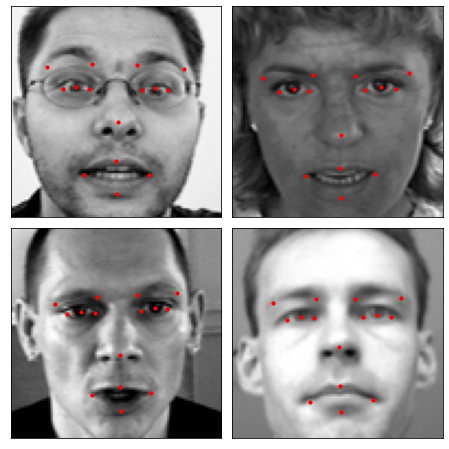

In [ ]:

# get the checkpoint file to load the weights
model.load_weights(filepath)

# Load testing set
X_test, _ = loadData(False)

print("Test data shape == {}".format(X_test.shape))

predictions = model.predict(X_test)
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(4):
    ax = fig.add_subplot(2, 2, i + 1, xticks=[], yticks=[])
    plotData(X_test[i], predictions[i], ax)

## **Part3**

Here, we will test our model with real time images. To test with real time images, first we need to detect faces in the frames. Although, Face detection and landmark detection task can be carried out together using CN Networks, it involves implementation of complex algorithm like YOLO algorithm. Since, we have open sourced face detection libraries like opencv and dlib, we can use them to detect faces. Dlib's implementation works better than opencv's since it uses HOG Features trained with SVM . Opencv uses Adaboost alogorithm trained Haar-like features and it is shown to have low accuracy on various faces datasets like FDDB. 

[(273, 280) (325, 331)]


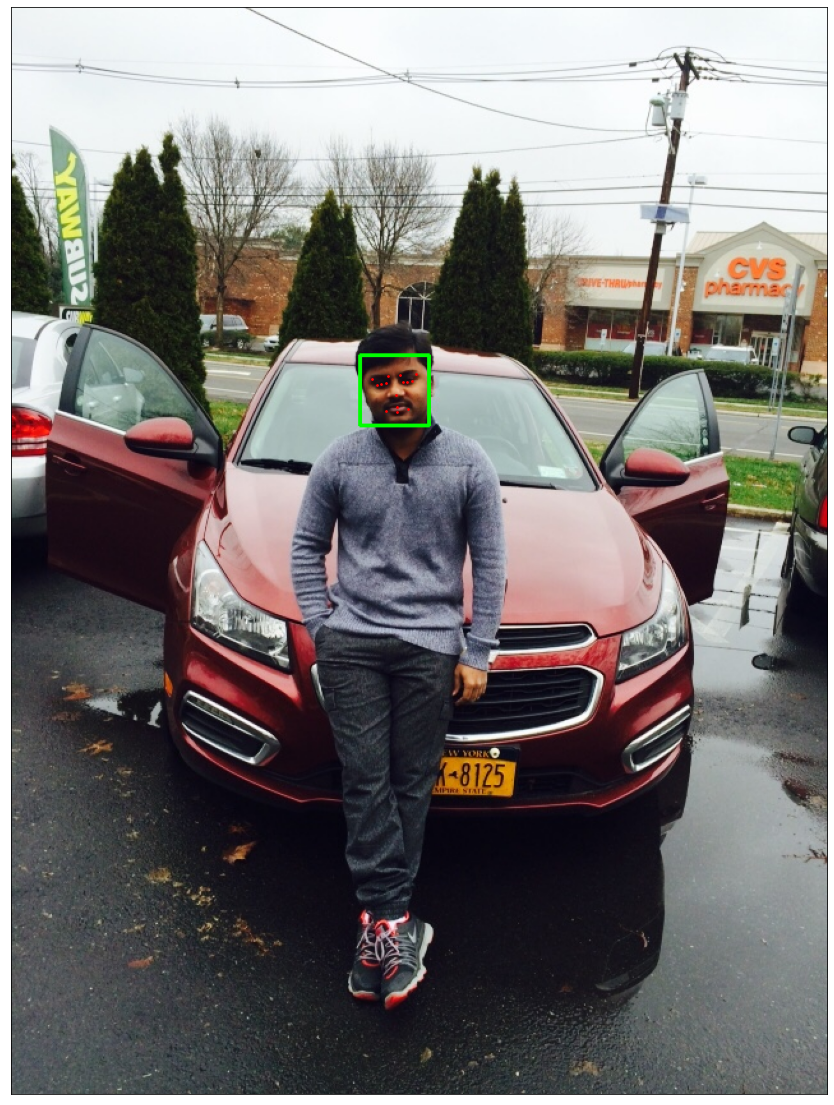

In [ ]:
import cv2
import dlib
import argparse
import time
from google.colab import files
import numpy as np
from keras.models import load_model

def rect_to_cord(face):
    h = face.bottom() - face.top()
    height_adj = int(h*0.15)
    h = h + int(0.7*height_adj)
    x = face.left()
    y = face.top() - height_adj
    w = face.right() - x
    w = w + int(w*0.05)
    return x,y,w,h

files.upload()
image_n = cv2.imread("IMG_4330.JPG")
image = cv2.cvtColor(image_n, cv2.COLOR_BGR2RGB)

fig1 = plt.figure(figsize=(20,20))
ax1 = fig1.add_subplot(1, 1, 1, xticks=[], yticks=[])

detector = dlib.get_frontal_face_detector()
rects = detector(image, 1)

for (i,rect) in enumerate(rects):
  x,y,w,h = rect_to_cord(rect)
  cv2.rectangle(image, (x,y), (x+w,y+h), (0, 255, 0), 2);
  detection = image[y:y+h, x:x+w]
  print(rect)
  detect_copy = np.copy(detection)
  test_image = cv2.cvtColor(detection, cv2.COLOR_RGB2GRAY)
  test_image = cv2.resize(test_image,(96,96))/255
  test_image = np.expand_dims(test_image, axis=0)
  test_image = np.expand_dims(test_image, axis=3)
  model = load_model('my_model.h5')
  predictions =  np.squeeze(model.predict(test_image))
  y_scale = (detect_copy.shape[0])/96
  x_scale = (detect_copy.shape[1])/96
  ax1.scatter(((predictions[0::2] * 48 + 48)*x_scale)+x,((predictions[1::2]*48+48)*y_scale)+y, 
                   marker='o', c='r', s=3)

ax1.imshow(image)
fig1.savefig("detections.jpg")

Saving mmod_human_face_detector.dat to mmod_human_face_detector (1).dat


NameError: ignored

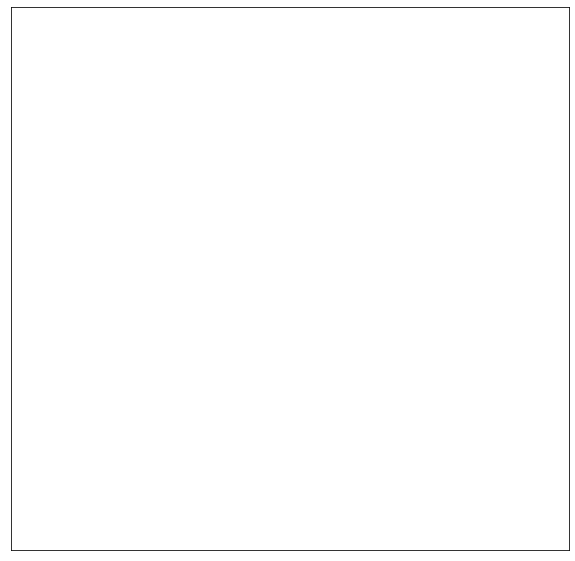

In [ ]:
import cv2
import dlib
import argparse
import time
from google.colab import files
import numpy as np
from keras.models import load_model

def rect_to_cord(face):
    x = face.left()
    y = face.top()
    w = face.right() - x
    h = face.bottom() - y
    return x,y,w,h

files.upload()
image_n = cv2.imread("test_3.jpg")
image = cv2.cvtColor(image_n, cv2.COLOR_BGR2RGB)

fig1 = plt.figure(figsize=(10,10))
ax1 = fig1.add_subplot(1, 1, 1, xticks=[], yticks=[])

detector = dlib.cnn_face_detection_model_v1('mmod_human_face_detector.dat')
rgb_small_frame = small_frame[:, :, ::-1]
for (i,rect) in enumerate(rects):
  x,y,w,h = rect_to_cord(rect)
  cv2.rectangle(image, (x,y), (x+w,y+h), (0, 255, 0), 2);
  detection = image[y:y+h, x:x+w]
  print(rect)
  detect_copy = np.copy(detection)
  test_image = cv2.cvtColor(detection, cv2.COLOR_RGB2GRAY)
  test_image = cv2.resize(test_image,(96,96))/255
  test_image = np.expand_dims(test_image, axis=0)
  test_image = np.expand_dims(test_image, axis=3)
  model = load_model('my_model.h5')
  predictions =  np.squeeze(model.predict(test_image))
  y_scale = (detect_copy.shape[0])/96
  x_scale = (detect_copy.shape[1])/96
  ax1.scatter(((predictions[0::2] * 48 + 48)*x_scale)+x,((predictions[1::2]*48+48)*y_scale)+y, 
                   marker='o', c='r', s=2)

ax1.imshow(image)

Number of faces detected: 2


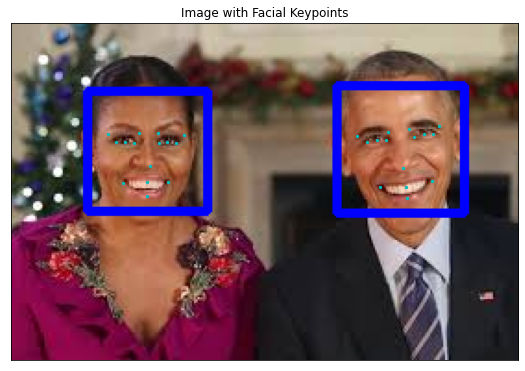

In [ ]:

def plot_keypoints(img_path, face_cascade_path, scale=1.1, neighbors=10, key_size=5):
    
    face_cascade=cv2.CascadeClassifier(face_cascade_path) 
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scale, neighbors)
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(121, xticks=[], yticks=[])
    ax.set_title('Image with Facial Keypoints')

    # Print the number of faces detected in the image
    print('Number of faces detected:', len(faces))

    # Make a copy of the orginal image to draw face detections on
    image_with_detections = np.copy(img)

    # Get the bounding box for each detected face
    for (x,y,w,h) in faces:
        # Add a red bounding box to the detections image
        cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (255,0,0), 3)
        bgr_crop = image_with_detections[y:y+h, x:x+w] 
        orig_shape_crop = bgr_crop.shape
        gray_crop = cv2.cvtColor(bgr_crop, cv2.COLOR_BGR2GRAY)
        resize_gray_crop = cv2.resize(gray_crop, (96, 96)) / 255
        #model = load_model(model_path)
        landmarks = np.squeeze(model.predict(
            np.expand_dims(np.expand_dims(resize_gray_crop, axis=-1), axis=0)))
        ax.scatter(((landmarks[0::2] * 48 + 48)*orig_shape_crop[0]/96)+x, 
                   ((landmarks[1::2] * 48 + 48)*orig_shape_crop[1]/96)+y, 
                   marker='o', c='c', s=key_size)
        
    ax.imshow(cv2.cvtColor(image_with_detections, cv2.COLOR_BGR2RGB))

plot_keypoints("obama.jpeg", "haarcascade_frontalface_default.xml")

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
